# **Lennard-Jones gas**

In this code we simulate a set of N particles subjected to Lennard-Jones interactions and confined in a 2D rectangular box. We do this by using the 12-6 Lennard-Jones potential. Then, we solve numerically the Newton's law of motion using Runge-kutta 4. Besides, we use a rustic method of adaptive step by reducing the time step when two particles are *close enough*. The condition for *close enough* is that any of the forces between the particles be greater than or equal to `F0`, which is the Lennard-Jones force between two particles at some distant `R0`. This distance must be choose by the user.

**Credits**
* Juan Andrés Guarín Rojas
* [GitHub](https://github.com/AndresGuarin)

# **Import libraries**

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# **1. Computational scheme**

We consider a gas composed of neutral identical particles that interact between each other by the Lennard-Jones potential

$$V_{ij} = 4 \epsilon \left[\left( \frac{\sigma}{r_{ij}} \right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^{6} \right]$$

which led to a force on the ith particle of
$$ \vec{F}_{i} = 24\epsilon \sum\limits_{j=1}^{N} \left[\frac{2\,\sigma^{12}}{r_{ij}^{13}}-\frac{\sigma^6}{r_{ij}^7}  \right] \hat{r}_{ij}$$ 

where $\vec{r}_{ij}=\vec{r}_i-\vec{r}_j$


For implementing this equations into the code we define the next dimensionless quantities:
$$\bar{t}=\sqrt{\frac{24\epsilon}{m\sigma}}t\,,$$
$$ \vec{r}' = \frac{\vec{r}}{\sigma}\,,$$
$$ \bar{r}_{ij} =\frac{r_{ij}}{\sigma}\,. $$

With this definitions the Newton's Law of motion left as
$$ \frac{d^2\vec{r}'_{i}}{d \bar{t}^2}=\sum\limits_{j=1}^{N}\left(\frac{2}{\bar{r}_{ij}^{13}}-\frac{1}{\bar{r}_{ij}^7} \right) \hat{r}'_{ij}\,.$$ 

In [177]:
class LJGas:
    def __init__(self,h=0.05,N=100,Np=2,R0=1.05,h0=0.01,box=[20,10],verbose=False):
        # Dynamic parameters
        self.h = h  # Time lapse between steps
        self.N = N   # Number of steps
        self.Np = Np    # Number of particles

        # Other parameters
        self.h1 = self.h
        self.verbose = verbose

        # Control parameters
        self.R0 = R0                        # Distance of contact
        self.F0 = 2/self.R0**13-1/self.R0**7  # Force of contact
        self.h0 = h0   # Time step for contact events

        # Rectangular box parameters
        self.box = box
        self.lim = [box[0]/2*1.1, box[1]/2*1.1]

    def get_self(self):
        return self

    # Functions
    def Fk(self,X,Y,Vx,Vy):
        # Associated matrixes of distance and force
        I = np.eye(self.Np)
        A, B = np.meshgrid(X,X); dX = A-B
        A, B = np.meshgrid(Y,Y); dY = A-B 
        R = np.sqrt(dX**2+dY**2) + I
        F = 2/R**13-1/R**7
        Ax1 = F*dX/R
        Ay1 = F*dY/R

        # Flatten vectors
        Ax = np.sum(Ax1,axis=0)
        Ay = np.sum(Ay1,axis=0)
        return np.array([Vx, Vy, Ax, Ay])

    def simulate(self,CI):
        LX = np.zeros((self.N+1,self.Np))
        LY = np.zeros((self.N+1,self.Np))
        LVx = np.zeros((self.N+1,self.Np))
        LVy = np.zeros((self.N+1,self.Np))
        self.Lh = np.zeros(self.N+1)

        LX[0] = CI[0]
        LY[0] = CI[1]
        LVx[0] = CI[2]
        LVy[0] = CI[3]
        self.Lh[0] = self.h

        self.LContacts = []
        self.aux = 0

        for i in range(self.N):
            next_val, F1 = self.next_value(LX[i],LY[i],LVx[i],LVy[i])
            LX[i+1] = next_val[0]
            LY[i+1] = next_val[1]
            LVx[i+1] = next_val[2]
            LVy[i+1] = next_val[3]
            
            if np.max(F1) >= self.F0: 
                self.h = self.h0
                if self.aux==0: self.LContacts.append([i])
                self.aux = 1
                if self.verbose: print('here',i,self.h)
                
            else: 
                self.h = self.h1
                if self.aux ==1: 
                    self.LContacts[-1].append(i)
                    if self.verbose: print('here',i,self.h)
                    self.aux = 0
            self.Lh[i+1] = self.h

        return [LX, LY, LVx, LVy]

    def next_value(self,X,Y,Vx,Vy):
        """
            Calculates the next positions and velocities after a time lapse of self.h
            Find the 4 k-values of the Runge-Kutta method (RK4)
            @params
            X,Y,Vx,Vy:
                np.array of the position and velocity of the particles

            @returns
            xf,yf,vxf,vyf
                np.array that contains the final positions and velocities of the particles
        """
        #K1 and calculations
        K1 = self.h*self.Fk(X,Y,Vx,Vy)
        X1 = X + K1[0]/2
        Y1 = Y + K1[1]/2
        Vx1 = Vx + K1[2]/2
        Vy1 = Vy + K1[3]/2

        F1 = np.sqrt(K1[2]**2+K1[3]**2)/self.h #net force

        #K2 and calculations
        K2 = self.h*self.Fk(X1,Y1,Vx1,Vy1)
        X2 = X + K2[0]/2
        Y2 = Y + K2[1]/2
        Vx2 = Vx + K2[2]/2
        Vy2 = Vy + K2[3]/2

        #K3 and calculations
        K3 = self.h*self.Fk(X2,Y2,Vx2,Vy2)
        X3 = X + K3[0]
        Y3 = Y + K3[1]
        Vx3 = Vx + K3[2]
        Vy3 = Vy + K3[3]

        #K4 and calculating final positions
        K4 = self.h*self.Fk(X3,Y3,Vx3,Vy3)
        Xf = X + 1/6*(K1[0] + 2*K2[0] + 2*K3[0] + K4[0])
        Yf = Y + 1/6*(K1[1] + 2*K2[1] + 2*K3[1] + K4[1])
        Vxf = Vx + 1/6*(K1[2] + 2*K2[2] + 2*K3[2] + K4[2])
        Vyf = Vy + 1/6*(K1[3] + 2*K2[3] + 2*K3[3] + K4[3])
        return np.array([Xf, Yf, Vxf, Vyf]), F1

    def get_net_force(self,s):
        X1 = s[0][:,0]; X2 = s[0][:,1]
        Y1 = s[1][:,0]; Y2 = s[1][:,1]
        R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)
        F = 2/R**13-1/R**7
        return F

    def get_Energy(self,s):
        X1 = s[0][:,0]; X2 = s[0][:,1]
        Y1 = s[1][:,0]; Y2 = s[1][:,1]
        VX1 = s[2][:,0]; VX2 = s[2][:,1]
        VY1 = s[3][:,0]; VY2 = s[3][:,1]
        R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)
        Ek = 1/2*(VX1**2+VY1**2+VX2**2+VY2**2)
        V = 1/(6*R**12)-1/(6*R**6)
        return [Ek,V,Ek+V]

In [260]:
# Animation functions

def get_uniform(self,M):
    """
    @params 
        M :  np.array of data of the motion as LX, LY, LVx, and LVy. 
             It can be for example s[0], s[1], time
    """
    slice_step = int(self.h/self.h0)
    i0 = self.LContacts[0][0]
    Ls = [M[:i0]]
    for k in range(len(self.LContacts)-1):
        i,j = self.LContacts[k]
        i1,j1 = self.LContacts[k+1]
        Ls.append(M[i:j:slice_step])
        Ls.append(M[j:i1])
    i1,j1 = self.LContacts[-1]
    Ls.append(M[i1:j1:slice_step])
    Ls.append(M[j1:])
    s1 = np.concatenate(Ls)
    return s1

def animate_path(self,s,duration=5,kind=0,save=False,name=None,verbose=True,plot_params=['-b','or',0.5,5]):
    """
    @params:
        self: self object that contains the data of 
              LJGas object.
    """

    # Time list
    Lh = self.Lh
    time = np.zeros(self.N+1)
    for i in range(self.N):
        time[i+1] = time[i]+Lh[i]

    # Make the steps uniform
    LX1 = get_uniform(self,s[0])
    LY1 = get_uniform(self,s[1])
    time1 = get_uniform(self,time)
    
    # Plot parameters
    fmt1 = plot_params[0]
    fmt2 = plot_params[1]
    lw1 = plot_params[2]
    ms1 = plot_params[3]

    #local function for update each frame
    def update(j):    
        ax.clear() # Clear the before plot
        
        # Plot positions
        if kind==0:
            for i in range(self.Np):
                ax.plot(LX1[:j,i],LY1[:j,i],fmt1,lw=lw1)
                ax.plot(LX1[j,i], LY1[j,i], fmt2,ms=ms1)

        if kind==1:
            for i in range(self.Np): ax.plot(LX1[j,i], LY1[j,i], fmt2,ms=ms1)

        # Put on legend the Iteration and time of the frame
        ax.plot(0,0,'o',ms=0, label=r'$n=$'+f'{j}')
        ax.plot(0,0,'o',ms=0, label=r'$\overline{t}=$ '+f'{np.round(time1[j],1)}')
        
        # Put grids, legends, and limits
        if verbose: plt.legend()
        plt.xlim(-self.lim[0], self.lim[0])
        plt.ylim(-self.lim[0], self.lim[0]) 
    
    # Create figure and axis
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    
    # Put labels, title, grids, and legend
    plt.xlabel(r'$\overline{x}$')
    plt.ylabel(r'$\overline{y}$')
    plt.title('Lennard-Jones Gas of N partilces')
    #plt.grid()
    plt.legend()
    
    # Set the steps of the animation
    local_time = 0.25   # Empirical time in seconds that matplotlib.pyplot lasts for each plot of the animation
    N_frames = duration/local_time
    step = int(self.N/N_frames)
    Nf = LX1.shape[0]

    # Animate the movement
    ani = animation.FuncAnimation(fig,update,range(1,Nf,step), repeat=False) 
    
    if save: ani.save(name,writer='ffmpeg')
    plt.show(ani)

# **2. Simulation of the colision of two particles**

In [276]:
# Choose parameters 
h = 0.05; N = 120; Np = 2; R0 = 1.05; h0 = 0.01

# Set intial conditions
X0 = np.array([0,2])
Y0 = np.array([0,0])
Vx0 = np.array([0.5,0])
Vy0 = np.array([0,0])

sim = LJGas(h,N,Np,R0,h0,verbose=True,box=[6,5])
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

here 35 0.01
here 36 0.01
here 37 0.01
here 38 0.01
here 39 0.01
here 40 0.01
here 41 0.01
here 42 0.01
here 43 0.01
here 44 0.01
here 45 0.01
here 46 0.01
here 47 0.01
here 48 0.01
here 49 0.01
here 50 0.01
here 51 0.01
here 52 0.01
here 53 0.01
here 54 0.01
here 55 0.01
here 56 0.01
here 57 0.01
here 58 0.01
here 59 0.01
here 60 0.01
here 61 0.01
here 62 0.01
here 63 0.01
here 64 0.01
here 65 0.01
here 66 0.01
here 67 0.01
here 68 0.01
here 69 0.01
here 70 0.01
here 71 0.01
here 72 0.01
here 73 0.01
here 74 0.01
here 75 0.01
here 76 0.01
here 77 0.05


In [300]:
#plt.plot(time)
Lh[36]

0.01

In [278]:
%matplotlib inline

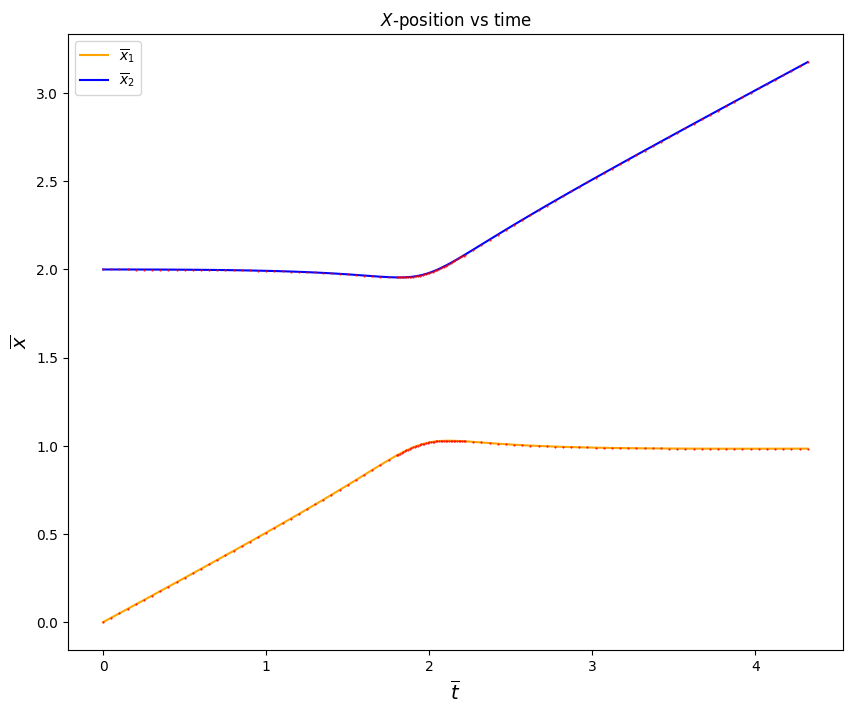

In [279]:
X1 = s[0][:,0]
X2 = s[0][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-position vs time')
plt.ylabel(r'$\overline{x}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,X1,'-',color='orange',label=r'$\overline{x}_1$') ;plt.plot(time,X1,'o',color='red', ms=0.5)
plt.plot(time,X2,'-b',ms=0.5,label=r'$\overline{x}_2$')        ;plt.plot(time,X2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.legend()
plt.savefig('images/2ParticlesGas/x_position.png',dpi=350)
plt.show()

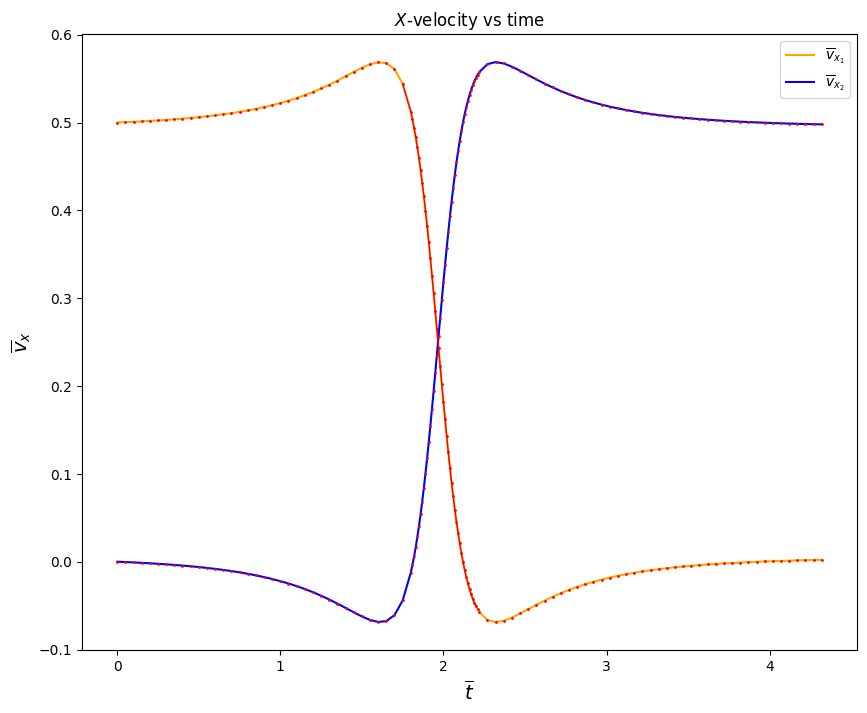

In [280]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-velocity vs time')
plt.ylabel(r'$\overline{v}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1,'-',color='orange',label=r'$\overline{v}_{x_1}$') ;plt.plot(time,VX1,'o',color='red', ms=1)
plt.plot(time,VX2,'-b',ms=0.5,label=r'$\overline{v}_{x_2}$')        ;plt.plot(time,VX2,'o',color='red', ms=1)

plt.legend()
plt.plot(time[35:77],VX1[35:77],'-',color='red',lw=1)
plt.savefig('images/2ParticlesGas/x_velocity.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

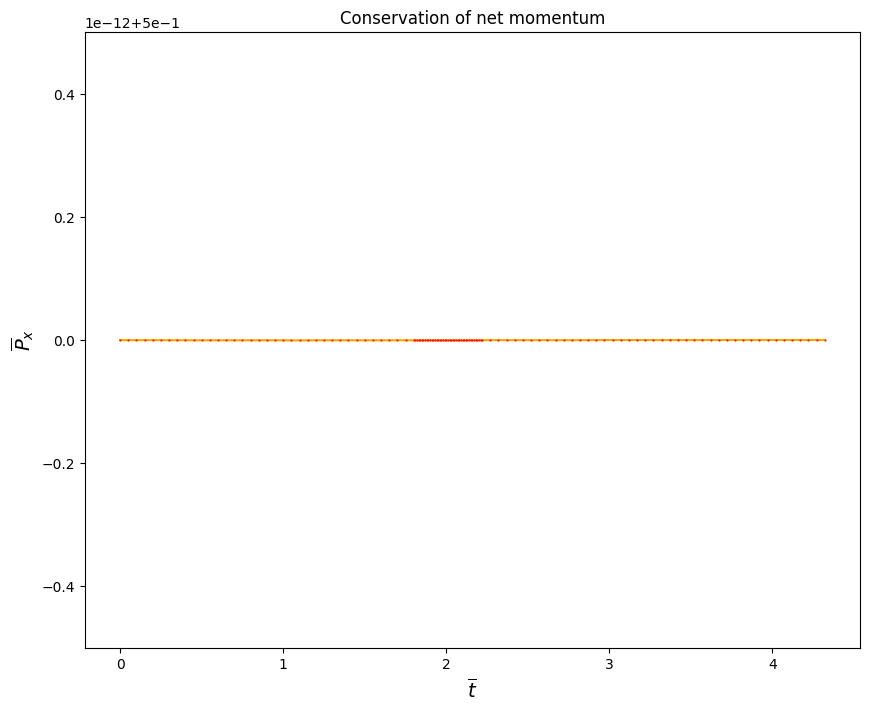

In [281]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title('Conservation of net momentum')
plt.ylabel(r'$\overline{P}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1+VX2,'-',color='orange') ;plt.plot(time,VX1+VX2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.savefig('images/2ParticlesGas/x_net_momentum.png',dpi=350)
plt.show()

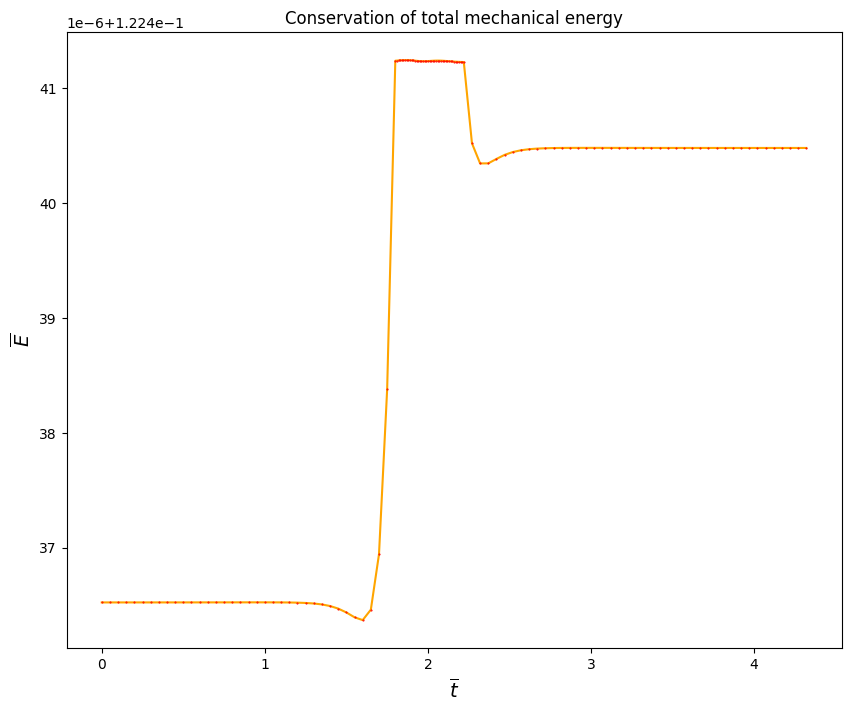

In [282]:
Em = sim.get_Energy(s)[2]

plt.figure(figsize=(10,8))
plt.title('Conservation of total mechanical energy')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,Em,'-',color='orange') ;plt.plot(time,Em,'o',color='red', ms=0.5)
plt.savefig('images/2ParticlesGas/net_mechanical_energy.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

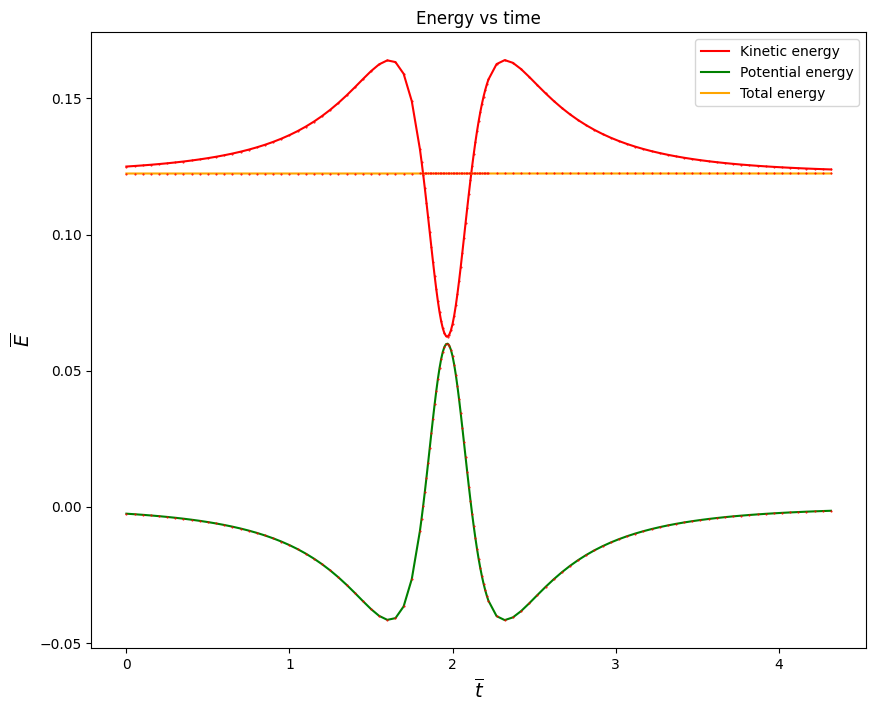

In [283]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy vs time')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red',label = 'Kinetic energy') ;plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V,'-',color='green',label = 'Potential energy') ;plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em,'-',color='orange',label = 'Total energy') ;plt.plot(time, Em,'o',color='red', ms=0.5)
plt.legend()
plt.savefig('images/2ParticlesGas/energy_vs_time.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

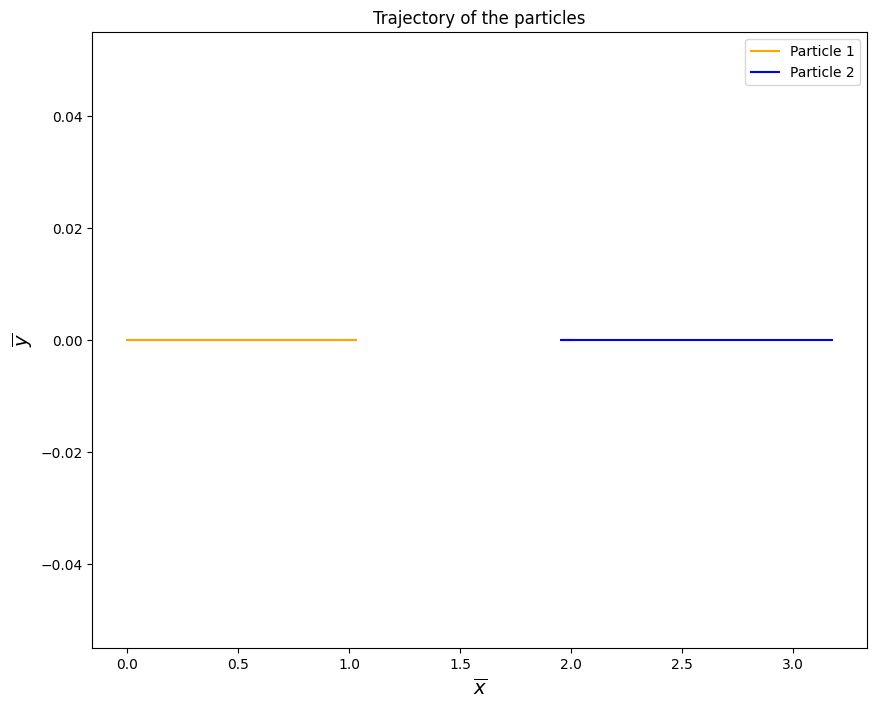

In [298]:
X1 = s[0][:,0]
X2 = s[0][:,1]
Y1 = s[1][:,0]
Y2 = s[1][:,1]

plt.figure(figsize=(10,8))
plt.title(r'Trajectory of the particles')
plt.xlabel(r'$\overline{x}$',fontsize=14)
plt.ylabel(r'$\overline{y}$',fontsize=14)
plt.plot(X1,Y1,'-',color='orange',label='Particle 1') #;plt.plot(X1,Y1, 'o',color='red', ms=0.5)
plt.plot(X2,Y2,'-b',ms=0.5,label='Particle 2')        #;plt.plot(X2,Y2, 'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.legend()
plt.savefig('images/2ParticlesGas/trajectory.png',dpi=350)
plt.show()

In [296]:
%matplotlib inline

In [286]:
%matplotlib auto
%matplotlib auto

Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg


In [ ]:
animate_path(self1,s,duration=5,kind=0,save=False,verbose=True,plot_params=['-b','or',1.5,20])
plt.show()

In [93]:
X1 = s[0][:,0]; X2 = s[0][:,1]
Y1 = s[1][:,0]; Y2 = s[1][:,1]
R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)

In [55]:
dX1 = X1[1:]-X1[0:-1]
v_num = dX1/h
VX1 = s[2][:,0]; VY1 = s[3][:,0]
VX2 = s[2][:,1]; VY2 = s[3][:,1]
V1 = np.sqrt(VX1**2+VY1**2)
V2 = np.sqrt(VX2**2+VY2**2)

In [56]:
CR = -(V1[-1]-V2[-1])/(V1[0]-V2[0]) #Coeficient of restitution
CR

0.9913914363569386

In [57]:
aux = V1[0:-1]-v_num
aux[17:57]

array([-9.71477193e-04, -1.07698786e-03, -1.19419484e-03, -1.32386990e-03,
       -1.46644483e-03, -1.62170290e-03, -1.78826766e-03, -1.96275750e-03,
       -2.13838648e-03, -2.30264170e-03, -2.43341621e-03, -2.49256005e-03,
       -2.41515577e-03, -2.09189925e-03, -1.34104416e-03,  1.33136663e-04,
        2.79157315e-03,  7.29072562e-03,  1.43884570e-02,  4.10750573e-01,
        4.03864046e-01,  3.96266026e-01,  3.87925202e-01,  3.78815622e-01,
        3.68918205e-01,  3.58222321e-01,  3.46727362e-01,  3.34444228e-01,
        3.21396621e-01,  3.07622049e-01,  2.93172416e-01,  2.78114104e-01,
        2.62527474e-01,  2.46505726e-01,  2.30153131e-01,  2.13582678e-01,
        1.96913238e-01,  1.80266391e-01,  1.63763093e-01,  1.47520385e-01])

In [294]:
aux[0:20]

array([-0.00019471, -0.00021218, -0.00023146, -0.00025275, -0.0002763 ,
       -0.00030237, -0.00033126, -0.00036332, -0.00039893, -0.00043853,
       -0.0004826 , -0.0005317 , -0.00058644, -0.00064752, -0.00071569,
       -0.00079179, -0.00087674, -0.00097148, -0.00107699, -0.00119419])

# **3. Simulation of 30 particles**

# **Anexos**

In [ ]:
# Partition an array

X = np.arange(1,101)
LC = [[9,19],[39,69]]
slice_step=2

i0 = LC[0][0]
Ls = [X[:i0]]
for k in range(len(LC)-1):
    i,j = LC[k]
    i1,j1 = LC[k+1]
    Ls.append(X[i:j:slice_step])
    Ls.append(X[j:i1])
Ls.append(X[i1:j1:slice_step])
Ls.append(X[j1:])
X1 = np.concatenate(Ls)
X1